# Environment Setup


In [ ]:
pip install mesa==0.8.6

# Model

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Thu Sep 26 16:41

Tue May 5, 10:39 2020
v0.15: Update price function, minimum threshold to become a member, portion of 
       attitude or subjective norm.

Tue Apr 28 10:14 2020
v0.14: Change the flow of attitude and subjective norm to follow the extensive
       game that models the situation better.

Sun Jan 12 16:50 2019
v0.13: Clean up codes after introducing TPB into the model.

Wed Dec 25 21:25 2019
v0.12: Set baseline for new improvement.

Tue Nov 26 18:39 2019
v0.11: Added parameters for consensus and conflict payoff. 

Sun Nov 24 11:53 2019
v0.10: Added aspiration-based learning and changed the logic that all members
       consider to exit if a conflict occurs. 

Tue Nov 12 19:30 2019
v0.9: Added a function to exit the group after experiencing conflicts. 

Tue Nov 12 14:13 2019
v0.8: Added a function to calculate new learning level after experiencing
      conflicts. 

Sun Nov 10 18:11 2019
v0.7: Updated the comments. 

Sat Nov 9 22:07 2019
v0.6: Changed substantially to include conflict process and group task status.      

v0.5: Updated maximum working hours per agent based on learning rate of all 
      agents in a task.

@author: Albert Yosua
"""

from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

#from scipy.stats import truncnorm

import random
#import numpy
#import itertools
import networkx as nx
import math
#import numpy as np
import pandas as pd

class FarmerAgent(Agent):
    """ An agent."""
    def __init__(self, 
                 unique_id, 
                 model,
                 learning_rate
                 ):
        super().__init__(unique_id, model)
        self.learning_rate = learning_rate
        self.aspiration = 0 # Real value
        self.total_payoff = 0
        self.current_payoff = 0
        # Two intentions determining the conflict-resolving behavior
#        self.assertiveness = 0.9
#        self.cooperativeness = 0
#        self.cooperativeness = random.choice([0.1])
#        self.cooperativeness = round(random.uniform(0.1, 0.9), 1)        
#        self.subjective_norm = round(random.uniform(0.1, 0.9), 1)        
#        self.attitude = round(random.uniform(0.6, 0.9), 1)
        self.attitude = 0
#        self.attitude = 0.6
#        self.subjective_norm = self.attitude
#        self.subjective_norm = round(random.uniform(0.1, 0.9), 1)
        self.subjective_norm = 0
#        self.behavioral_control = self.attitude
        self.behavioral_control = round(random.uniform(0.1, 0.9), 1)
#        self.behavioral_control = self.attitude
        self.intention = 0
        self.aspiration_rescaling = 0
        self.stimulus = 0
        self.exit = 0
        self.member = 0
        self.survive = 0
    
    def step(self):
        # Aspiration will be updated as long as the agent has not exited
        # or not yet a member
        if self.exit == 0:
            update_aspiration_static_ex(self)
#            calculate_payoff_static_ex(self)
        else:
            self.stimulus = 0
            self.current_payoff = 0
        
        self.total_payoff += self.current_payoff

def update_aspiration_static_ex(self):
    # Previous step's value
    # Amount of money that an agents aspires to get in joining co-op
    asp = self.aspiration
    profit = 0
    
    if self.member == 1:      
        # During joining the co-op, an agent checks profit they receive
        # Update aspiration value based on received profit
        if self.model.farmer_profit_amount > 0:           
            profit = self.model.farmer_profit_amount
            
            # Update aspiration
            dynamic = self.model.is_aspiration_dynamic           
            if dynamic:
                # Only the best payoff to be aspiration value
#                if profit > self.aspiration:
#                    self.aspiration = profit
                 # Habituation concept
                 h = self.model.learning_rate_asp                 
                 self.aspiration = (1 - h) * asp + h * profit
        
#        self.total_payoff = profit
    
        # Real value
        self.stimulus = profit - asp
        
        # Update the attitude level.    
        stimulus = self.stimulus
        
    #    s = stimulus / self.model.max_payoff
        if stimulus != 0 and asp != 0:
            s = stimulus / self.model.max_payoff
        else:
            s = 0
        
    #    print("s:", s)
            
    #    l_r = 0.3
        l_r = self.learning_rate
        a = self.attitude
    
        if s >= 0:        
            a = a + (1 - a) * l_r * s
        else:        
            a = a + a * l_r * s
    
        self.attitude = a
        
    else:
        # Current decision is still not joining the co-op
        profit = 0


    
    self.current_payoff = profit
#    self.total_payoff += profit


#    print("{:.2f}".format(self.attitude))
    
    # Update the subjective norm level
     # Get other agents connected to this agent.
    connections = list(self.model.network.neighbors(self.unique_id))
    
    # Update the value of cooperativeness level based on other agents' values.
    # Based on Friedkin and Johnsen, 2011
    if len(connections) > 0:
        n = len(connections)
        agents_list = [agent for agent in self.model.schedule.agents
                       if agent.unique_id in connections]
        
        sum_cooperativeness = 0
#        for agent in agents_list:
#            peer_cooperativeness = 0            
#            if agent.cooperativeness > 0.50:
#                peer_cooperativeness = 1                
#            sum_cooperativeness += (1 / n) \
#                * (peer_cooperativeness - self.subjective_norm)        
        for agent in agents_list:
            peer_cooperativeness = 0            
            if agent.member == 1:
                peer_cooperativeness = 1                
            sum_cooperativeness += (1 / n) \
                * (peer_cooperativeness - self.subjective_norm) 
            
        self.subjective_norm += self.model.learning_rate_sn \
                                * sum_cooperativeness
#        self.subjective_norm += self.learning_rate * sum_cooperativeness
        
    # Make sure the upper and lower range is between 0 and 1.
    if self.subjective_norm > 1:
        self.subjective_norm = 1
    elif self.subjective_norm < 0:
        self.subjective_norm = 0
    
#    # Update aspiration ---> moved to model step
#    # Range: [0,1]
#    attitude_portion = self.model.attitude_portion
#    if self.member == 0:
#        # Not already joined members only use the subjective norm
##        attitude_portion = 0.5
#        attitude_portion = 0.5
##    if self.member == 1 and \
##        self.exit == 0 and \
##        self.unique_id in self.model.joined_agents_list:
##        attitude_portion = 1.0
#    self.aspiration_rescaling = (1 - attitude_portion) * self.subjective_norm \
#                                + attitude_portion * self.attitude

#    # Update intention ---> moved to model step                               
#    self.intention = self.aspiration_rescaling
    
#    # Update membership    ---> moved to model step
##    if self.intention <= 0.50 or self.subjective_norm <= 0.50:
#    if self.intention <= 0.50:
#        # Exit co-op if currently a member and thinks that it is not worth
#        if self.member == 1:
#            # Survive is effective for a newly joined members in high join
#            # portion initialisation value
#            if self.survive >= 0:
#                self.exit = 1
#            else:
#                self.survive += 1            
#    else:
#        # If not yet join, next step is to become a member
#        if self.member == 0:
#            self.member = 1
    



def update_aspiration(self):   
    
    attitude_portion = self.model.attitude_portion
#    if self.member == 0 and self.exit == 0:
#        # Not already joined members only use the subjective norm
##        attitude_portion = 0.5
#        attitude_portion = 0.5
    # Range: [0,1]
    self.aspiration_rescaling = (1 - attitude_portion) * self.subjective_norm \
                                + attitude_portion * self.attitude
    
def update_intention(self):
    self.intention = self.aspiration_rescaling

def update_membership(self):
#    if self.intention <= self.model.exit_threshold:
#        # Exit co-op if currently a member and thinks that it is not worth
#        if self.member == 1:
#            # Survive is effective for a newly joined members in high join
#            # portion initialisation value
#            if self.survive >= self.model.survive_threshold:
#                self.exit = 1
#            else:
#                self.survive += 1            
#    else:
#        # If not yet join, next step is to become a member
#        if self.member == 0:
#            self.member = 1
            
    # If not a member
    if self.member == 0:
        # Enter co-op if currently not a member
        if self.intention >= self.model.enter_threshold:
            self.member = 1
    # If a member or previously a member
    else:
        # If not yet exit
        if self.exit == 0:
            # Exit co-op if currently a member
            if self.intention < self.model.exit_threshold:
                self.exit = 1
   

#def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
#
#    return truncnorm(
#        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)
    
    
def get_total_cooperative_agents(model):
    cooperative_agents = sum(1 for agent 
                         in model.schedule.agents 
                         if agent.exit == 0 and agent.member == 1)
    
    return cooperative_agents

def get_farmer_profit_amount(model):
    return model.farmer_profit_amount


def get_total_defective_agents(model):
    cooperative_agents = sum(1 for agent 
                         in model.schedule.agents 
                         if not (agent.exit == 0 and agent.member == 1))
    
    return cooperative_agents

            
class FarmerModel(Model):
    """A model with some number of agents."""
    def __init__(self, 
                 N, 
                 learning_rate,
                 learning_rate_sn,
                 nearest_neighbors_number,
                 joined_agents,
                 is_aspiration_dynamic,
                 is_initial_members_pos_random,
                 attitude_portion,
                 enter_threshold,
                 exit_threshold,
                 survive_threshold,
                 learning_rate_asp,
                 profit_noise_max,
                 profit_noise_min,
                 network_type,
                 seed=None
                 ):
        
        self.num_agents = N
        self.learning_rate_sn = learning_rate_sn
        self.nearest_neighbors_number = nearest_neighbors_number
        self.is_aspiration_dynamic = is_aspiration_dynamic       
        self.is_initial_members_pos_random = is_initial_members_pos_random
        self.attitude_portion = attitude_portion
        self.enter_threshold = enter_threshold
        self.exit_threshold = exit_threshold
        self.survive_threshold = survive_threshold
        self.learning_rate_asp = learning_rate_asp
        self.profit_noise_max = profit_noise_max
        self.profit_noise_min = profit_noise_min
        self.network_type = network_type
        
        self.schedule = RandomActivation(self)
        # For batch set up
        self.running = True
        
        if self.network_type == 0:
            # Create a network
            # n - the number of nodes
            # k - each node is joined with its k nearest neighbours
            # p - the probability of rewiring each edge
            self.network = nx.watts_strogatz_graph(n=self.num_agents, 
                                                   k=self.nearest_neighbors_number, 
                                                   p=0.1, 
                                                   seed=seed)
        elif self.network_type == 1:
            self.network = nx.extended_barabasi_albert_graph(n=self.num_agents, 
                                                             m=self.nearest_neighbors_number, 
                                                             p=0.1, 
                                                             q=0.1, 
                                                             seed=seed)
        
        
#        self.network = nx.watts_strogatz_graph(10, 2, 0.1, seed=1)
#        self.network = nx.extended_barabasi_albert_graph(n=10, 
#                                                         m=3, 
#                                                         p=0.1, 
#                                                         q=0.1, 
#                                                         seed=1)
#        self.network = nx.extended_barabasi_albert_graph(n=10, m=1, p=0.1, 
#                                                         q=0.1, seed=1)
        
        
#        degree_sequence = sorted([d for n, d 
#                              in self.network.degree()], reverse=True)
        
        # Range: [0, x_max].
        # Assume both cooperative agents get the maximum payoff.
#        self.max_payoff = max(degree_sequence) * self.both_coll_payoff
        
        # Create agents based on node ID from the network
#        for i in range(self.num_agents):
        for i in self.network:
            a = FarmerAgent(i, self, 
                            learning_rate,
#                            max_aspiration,
#                            min_aspiration,
#                            both_coll_payoff,
#                            both_comp_payoff
                            )            
#            update_aspiration(a)  
#            update_intention(a)
#            update_cooperativeness(a)
            
#            update_subjective_norm(a)
            self.schedule.add(a)      
            
        # Update initial joined status
        joined_agents_num = round(joined_agents*N)
        
        pos_random = self.is_initial_members_pos_random
        if pos_random:
            # Select randomly
            joined_agents_list = random.sample(range(joined_agents_num), 
                                               joined_agents_num)
        
        else:
            # Select from top number of degrees
            sorted_degrees = sorted([(d, n) for n, d in self.network.degree()], 
                                     reverse=True)
            joined_agents_list = [n for d, n in 
                                  sorted_degrees[:joined_agents_num]]
        
        # All calls to random will output the same results 
#        random.seed(1)
        
        initial_members_threshold_bottom = self.enter_threshold
        initial_members_threshold_top = 0.99
        initial_non_members_threshold_bottom = 0.00
        initial_non_members_threshold_top = self.enter_threshold - 0.01
        
        self.joined_agents_list = joined_agents_list
        for a in self.schedule.agents:            
            # Initial members of a co-op
            if a.unique_id in joined_agents_list:
                a.attitude = \
                    round(self.random.
                          uniform(initial_members_threshold_bottom,
                                  initial_members_threshold_top), 2)
                a.subjective_norm = \
                    round(self.random.
                          uniform(initial_members_threshold_bottom,
                                  initial_members_threshold_top), 2)
            # Outsider
            else:
                a.attitude = \
                    round(self.random.
                          uniform(initial_non_members_threshold_bottom,
                                  initial_non_members_threshold_top), 2)
#                a.attitude = round(random.uniform(0.1, 0.5), 1)
                a.subjective_norm = \
                    round(self.random.
                          uniform(initial_non_members_threshold_bottom,
                                  initial_non_members_threshold_top), 2)
#                a.subjective_norm = round(random.uniform(0.6, 0.9), 1)
            update_aspiration(a)  
            update_intention(a)
#            update_cooperativeness(a)
            
        # Outsider -> Consider -> Member
        
        # Put the initial member to the highest degree of network
        
#        for a in self.schedule.agents:
#            update_aspiration(a)
#            update_intention(a)
#            update_cooperativeness(a)
            
        # Count how many agents joined the co-op (at initialisation only)
        self.join = 0;
        self.join = sum(1 for agent 
                        in self.schedule.agents 
                        if agent.intention > self.enter_threshold)
        
#        count = 0
        for a in self.schedule.agents:
            if a.intention > 0.50:
                a.member = 1
            # Take some outsiders to become members
            else:
                if a.intention > self.enter_threshold:
                    a.member = 1
#                    count += 1
        
        self.coop_profit_ratio = 0.2
        self.farmer_profit_ratio = 0.8 
        
#        members_portion = self.join / self.num_agents
#        sigmoid_val = 1/(1+math.exp(-20*(members_portion-0.1)))
#        self.profit_amount = 100 * sigmoid_val
        
#        self.profit_amount = round(random.uniform(10, 100), 1)
        
#        self.profit_amount = 10 * self.join
        
        # Proportional profit
#        portion = self.join / self.num_agents
#        self.profit_amount = portion**2 * 1000
#        self.max_payoff = self.farmer_profit_ratio / self.num_agents * 1000

        # Linear profit
#        self.profit_amount = 10 * self.join
#        self.max_payoff = 10 * self.num_agents
        
        # Logistic 
        self.var_b = 0.8
        portion = self.join / self.num_agents
        sigmoid_val = 1 / (1 + math.exp(-10 * (portion - self.var_b)))        
        self.profit_amount = sigmoid_val * 1000
#        self.max_payoff = self.farmer_profit_ratio / self.num_agents \
#                          * (1 / (1 + math.exp(-10 * (1 - self.var_b)))) * 1000
#        self.max_payoff = 80
        
        # NOTE: develop max_payoff so it can be calculated by given function
        a = pd.Series(list(range(1, self.num_agents+1)))
        a = a.divide(50)
        b = a.apply(lambda x: (1 / (1 + math.exp(-10 * (x - self.var_b)))) \
                    * 1000 *  self.farmer_profit_ratio / (x * self.num_agents))
        self.max_payoff = b.max()
        
        if self.join == 0:
            self.farmer_profit_amount = 0
        else:
            self.farmer_profit_amount = self.farmer_profit_ratio / self.join \
                                        * self.profit_amount        
        
#        self.max_payoff = self.farmer_profit_ratio * self.profit_amount
#        print(self.max_payoff)
                                           
        # Initial aspiration equals to the received profit
        for a in self.schedule.agents:
#            a.aspiration = self.farmer_profit_amount
            
            
            # Initial aspiration value
            
            # Low - 1 person
#            a.aspiration = self.max_payoff / self.num_agents
            
            # High - 10 persons
#            a.aspiration = self.farmer_profit_ratio / self.num_agents \
#                           * (1 / (1 + math.exp(-10 * (0.1 - self.var_b)))) \
#                           * 1000
            # Based on 10 persons
#            a.aspiration = b.iloc[9]
            
            # Based on percentage from the max payoff
            a.aspiration = 0.1 * self.max_payoff
                        

    
#            else:
#                a.aspiration = 0
                
#        print("Initial joined agents:", self.join)
#        for a in self.schedule.agents:
#            a.aspiration = self.farmer_profit_amount


#            print("Initial:", a.aspiration, self.farmer_profit_amount)
            
#        update_all_subjective_norm(self)        
            
        self.datacollector = DataCollector(
        # A function to call
        model_reporters={"cooperative_agents": get_total_cooperative_agents,
                         "defective_agents": get_total_defective_agents,
                         "farmer_profit": get_farmer_profit_amount
                         },  
        # An agent attribute
        agent_reporters={"current_payoff": "current_payoff",
                         "aspiration": "aspiration",
                         "total_payoff": "total_payoff",
                         "stimulus": "stimulus",
                         "attitude": "attitude",
                         "member": "member",
                         "exit": "exit",
                         "subjective_norm": "subjective_norm",
                         "intention": "intention",  
                         "survive": "survive",
                         "behavioral_control": "behavioral_control",
                         "aspiration_rescaling": "aspiration_rescaling",
                         })  
    def step(self):
        self.datacollector.collect(self)
        '''Advance the model by one step.'''
        self.schedule.step()
        
        # Update cooperativeness of all agents simultaneously
#        update_all_cooperativeness(self)
        
        
        
        for agent in self.schedule.agents:
            if agent.exit == 0:
                update_aspiration(agent)
                update_intention(agent)
                update_membership(agent)
        
        # Count how many agents joined the co-op
        self.join = sum(1 for agent 
                        in self.schedule.agents 
                        if agent.exit == 0 and
                        agent.member == 1)
        
        # Based on time
#        self.profit_amount = self.schedule.steps * 100 \
#                             * round(random.uniform(0.6, 0.9), 1)
        
        # Update new profit for next step according to specific criteria
#        self.profit_amount = round(random.uniform(900, 1000), 1)
        
        # Use sigmoid function
#        members_portion = self.join / self.num_agents
#        sigmoid_val = 1/(1+math.exp(-20*(members_portion-0.1)))
#        self.profit_amount = 100 * sigmoid_val
        
        # y = 10x
        # The profit is linear with increasing number of members
#        self.profit_amount = 10 * self.join
        
        # Proportional profit
#        portion = self.join / self.num_agents
#        self.profit_amount = portion**2 * 1000
        
        # Linear profit
#        self.profit_amount = 10 * self.join
        
        # Logistic profit
        portion = self.join / self.num_agents
        sigmoid_val = 1 / (1 + math.exp(-10 * (portion - self.var_b)))
        self.profit_amount = sigmoid_val * 1000
        
        if self.join == 0:
            self.farmer_profit_amount = 0
        else:
            self.farmer_profit_amount = self.farmer_profit_ratio / self.join \
                                        * self.profit_amount
            
            # Set the range of noise to profit
            noise = self.random.randint(self.profit_noise_min, 
                                   self.profit_noise_max)
#            print(noise)
#            noise = random.randint(0, 0)
            if (noise + self.farmer_profit_amount) < self.max_payoff and \
                (noise + self.farmer_profit_amount) > 0:
                self.farmer_profit_amount += noise
                                        
#        print("Joined:", self.join,
#              "Profit:", "{:.2f}".format(self.profit_amount), 
#              "Share:", "{:.2f}".format(self.farmer_profit_amount))
        
#        verify_available_working_status(self)
#        verify_completed_working_status(self)
                                        
#        for a in self.schedule.agents:    
#            if a.cooperativeness <= 0.50:
#                a.exit = 1

20it [00:00, 27.40it/s]
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 0, 'nearest_neighbors_number')

<Figure size 288x288 with 0 Axes>

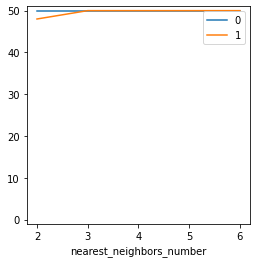

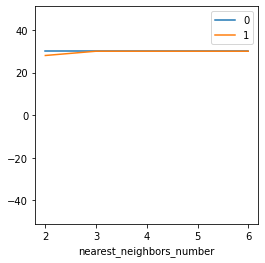

In [3]:
# run_batch_r_sn_n.py

from mesa.batchrunner import BatchRunner

# from model import FarmerModel

import numpy as np

num_iterations = 2
#number_of_agents = 50
number_of_steps = 30

fixed_params = {"N": 50,  # Number of agents
                "learning_rate": 0.35,
                "learning_rate_sn": 0.15,
#                "nearest_neighbors_number": 5,
                "joined_agents": 0.4,
                "is_aspiration_dynamic": 0, # Static: 0, Dynamic: 1
#                "is_initial_members_pos_random": 0, # High conn.: 0, Random: 1
                "attitude_portion": 0.2,
                "enter_threshold": 0.4,
                "exit_threshold": 0.3,
                "survive_threshold": 0,
                "learning_rate_asp": 0.9,
                "profit_noise_max": 5,
                "profit_noise_min": -5,
                "network_type": 1, # WS = 0, BA = 1
                }

range_1 = [2, 3, 4, 5, 6] # BA, nearest_neighbors_number - barabasi albert [1]

# range_1 = [4, 6, 8, 10, 12] # WS, nearest_neighbors_number - watts strogatz [0]

range_2 = [0, 1] # is_initial_members_pos_random
 
# Note: changing the value of parameter should be applied to plot section below
variable_params = {"nearest_neighbors_number": range_1,
                   "is_initial_members_pos_random": range_2
                   }

batch_run = BatchRunner(FarmerModel,
                        fixed_parameters=fixed_params,
                        variable_parameters=variable_params,
                        iterations=num_iterations,
                        max_steps=number_of_steps,
                        model_reporters={
#                            "Mean": compute_mean,
#                            "Stdev": compute_stdev,
                            "datacollector": lambda m: m.datacollector,
#                            "completed_time": lambda m: m.completed_time
                            },
#                        agent_reporters={
#                                "State": lambda a: a.current_state, 
#                              "Reward": lambda a: a.reward, 
#                             }
                        )
batch_run.run_all()



#plt.ylim(ymax=9)
#
#run_data = batch_run.get_model_vars_dataframe()
#run_data.head()
#plt.scatter(run_data.N, run_data.Mean, s=5)

run_data = batch_run.get_model_vars_dataframe()

#run_data_agent = batch_run.get_agent_vars_dataframe()



import pandas as pd
import seaborn as sns
import statistics 

import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))

#df_collection = {}
df_collection = pd.DataFrame(data=None, index=range_2, columns=range_1)
df_initial_collection = pd.DataFrame(data=None, index=range_2, columns=range_1)

for j in range_1:
    
    for k in range_2:
    
        df_temp_0 = run_data.query('nearest_neighbors_number==' + str(j) + ' and '
                               + 'is_initial_members_pos_random==' + str(k))
    
#    df_temp_0 = run_data.query('learning_rate==' + str(j))
    
        count = 0
        initial_members = []
        cooperative_agents = []
    #        ax = plt.gca()
    #    fig, (ax_1, ax_2) = plt.subplots(1,2,figsize=(8,4))
    #    fig, (ax_1) = plt.subplots(1,1,figsize=(8,4))
        for i in df_temp_0.iterrows():
            # Get each agent data
            df_temp \
                = i[1]['datacollector'].get_model_vars_dataframe().copy()    
                
            # Get all agents in specific status
            df_temp_count = df_temp.query('index == ' + str(number_of_steps - 1))
            
            cooperative_agents.append(df_temp_count.iloc[0]['cooperative_agents'])
            
            diff = df_temp.iloc[-1]['cooperative_agents'] - \
                   df_temp.iloc[0]['cooperative_agents']
            
            initial_members.append(diff)
    
#        plt.scatter(x=np.arange(0, num_iterations),
#                    y=cooperative_agents, 
#                    marker='o',
#                    label=j)    
    #    plt.ylim(-1, number_of_agents + 1)  
#        plt.ylim(-1, 50 + 1)
#        plt.legend()
    #    plt.figure(figsize=(4, 4))
    
#        print(k, j, cooperative_agents)
        df_collection.loc[k][j] = statistics.mean(cooperative_agents)
        df_initial_collection.loc[k][j] = statistics.mean(initial_members)
        
#        df_collection[str(j)+'_'+str(k)] = cooperative_agents

#    # Convert to dataframe
#    df_all = pd.DataFrame(df_collection)    
#    
#    df_all.mean().plot(ylim=(-1,51), figsize=(4,4))
    
df_collection.T.plot(figsize=(4,4),ylim=(-1,51))
plt.xlabel('nearest_neighbors_number')
df_initial_collection.T.plot(figsize=(4,4),ylim=(-51,51))
plt.xlabel('nearest_neighbors_number')

